In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

2024-07-29 03:03:15.236498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 03:03:15.285145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 03:03:15.310041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 03:03:15.318907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 03:03:15.343401: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Opting to display warnings for better understanding of potential issues
warnings.filterwarnings('default')

In [3]:
sns.set_theme()

# Indexing Image Directories

In [4]:
drive_path = "./"
df = pd.read_csv(drive_path + 'Data_Entry_2017.csv')
image_paths = {}

for subdir, _, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.png'):
            # Ensure the dictionary key is just the filename
            image_paths[file] = os.path.join(subdir, file)

print(f"Found {len(image_paths)} images.")

df['Image Path'] = df['Image Index'].apply(lambda x: image_paths.get(x))
df.to_csv(drive_path + 'Data_with_image_paths.csv')
df.head()

Found 112126 images.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,./images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,./images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,./images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,./images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,./images_001/images/00000003_000.png


# One hot encoding

In [5]:
mlb = MultiLabelBinarizer()
ohe_target = mlb.fit_transform(df['Finding Labels'])
ohe_df = pd.DataFrame(ohe_target, columns=mlb.classes_)
target_cols = ohe_df.columns.to_list()
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns='Finding Labels', inplace=True)

# Feature Label Encoding

In [6]:
le_gender = LabelEncoder()
le_view_position = LabelEncoder()
df['Patient Gender'] = le_gender.fit_transform(df['Patient Gender'])
df['View Position'] = le_view_position.fit_transform(df['View Position'])
df.to_csv(drive_path + 'final_dataset.csv')

# Creating training splits

In [7]:
df = pd.read_csv(drive_path + 'final_dataset.csv')
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=1997)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1997)

print(f'Training size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Testing size: {len(test_df)}')

Training size: 89696
Validation size: 11212
Testing size: 11212


# Training Splits

In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3  # Change to 3 for RGB images

# vgg expects images of sixe 224x224

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = data_augmentation(image)
    return image

def image_label_pairs(dataframe):
    image_paths = dataframe['Image Path'].values
    labels = dataframe.iloc[:, -15:].values
    return image_paths, labels

train_image_paths, train_labels = image_label_pairs(train_df)
val_image_paths, val_labels = image_label_pairs(val_df)
test_image_paths, test_labels = image_label_pairs(test_df)

def create_dataset(image_paths, labels, batch_size, shuffle=True, cache=True):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if cache:
        dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 64
train_dataset = create_dataset(train_image_paths, train_labels, batch_size)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_labels, batch_size, shuffle=False)

2024-07-29 03:03:22.363064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


# Define and compile the model

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(15, activation='sigmoid'))  # Change to match number of classes

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 15)             │     6,426,639 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,141,327 (80.65 MB)

 Trainable params: 21,141,327 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

# Adding early stopping and model checkpoint callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model and time the training process
start_time = time.time()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
end_time = time.time()

Epoch 1/20


2024-07-29 03:05:10.881801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3202 of 89696
2024-07-29 03:05:30.874473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 9924 of 89696
2024-07-29 03:05:40.875685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 13292 of 89696
2024-07-29 03:06:00.874074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 19957 of 89696
2024-07-29 03:06:10.878729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 23189 of 89696
2024-07-29 03:06:30.872488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may 

   1/1402 ━━━━━━━━━━━━━━━━━━━━ 113:49:28 292s/step - accuracy: 0.0000e+00 - loss: 0.8034

I0000 00:00:1722222589.761547   12874 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1402/1402 ━━━━━━━━━━━━━━━━━━━━ 497s 146ms/step - accuracy: 0.3760 - loss: 0.3867 - val_accuracy: 0.2759 - val_loss: 0.3503
Epoch 2/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 156s 111ms/step - accuracy: 0.4169 - loss: 0.3567 - val_accuracy: 0.3270 - val_loss: 0.3464
Epoch 3/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 156s 111ms/step - accuracy: 0.4156 - loss: 0.3525 - val_accuracy: 0.4528 - val_loss: 0.3414
Epoch 4/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.4771 - loss: 0.3457 - val_accuracy: 0.5343 - val_loss: 0.3450
Epoch 5/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.4545 - loss: 0.3395 - val_accuracy: 0.3399 - val_loss: 0.3420
Epoch 6/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.4853 - loss: 0.3328 - val_accuracy: 0.5102 - val_loss: 0.3417
Epoch 7/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.4889 - loss: 0.3213 - val_accuracy: 0.5021 - val_loss: 0.3415
Epoch 8/20
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 155s 110ms/step - accuracy: 0.4

# Evaluate the model

In [13]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Training Time: {end_time - start_time:.2f} seconds")

176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.4577 - loss: 0.3523
Test Accuracy: 45.54%
Training Time: 1580.19 seconds


# Plot the accuracy and loss curves

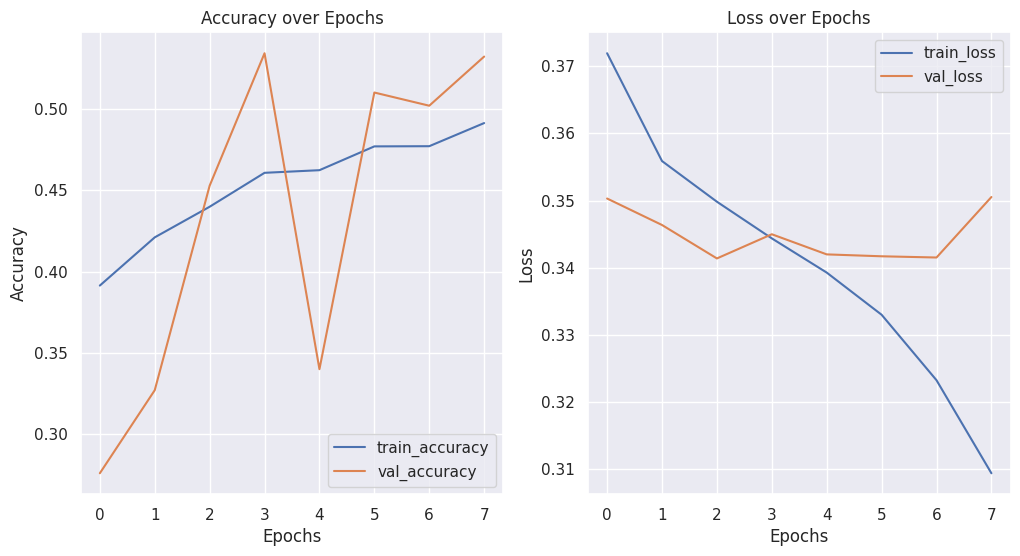

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['accuracy'], label='train_accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('Accuracy over Epochs')

ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Loss over Epochs')

plt.show()